## Introduction ##

This portion of the project picks up after the SQL query tasks. In this project, we're working as an analyst for a new ride-sharing company based in Chicago. Our goal is to find patterns in the available information to understand passenger preferences, the impact of external factors on ride frequency, and test a hypothesis based on our analysis. Specifically, we'll analyze weather data and trip data from our competitors to test if the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

Up to this point, we had worked with SQL databases containg data on neighborhoods, taxi companies, weather, and trip information for the Chicago area. In this portion of the project, we'll work with the following csv files containing the results similar to our previous SQL queries:

**project_sql_result_01.csv**  
- *company_name*: taxi company name  
- *trips_amount*: the number of rides for each taxi company on November 15-16, 2017

**project_sql_result_04.csv**  
- *dropoff_location_name*: Chicago neighborhoods where rides ended  
- *average_trips*: the average number of rides that ended in each neighborhood in November 2017  

**project_sql_result_07.csv**  
- *start_ts*: pickup date and time (only includes Saturdays for Novemeber 2017)
- *weather_conditions*: weather conditions at the moment the ride started  
- *duration_seconds*: ride duration in seconds

## Imports and Reading the Data ##

**Packages, Libraries, and Modules**

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats as st

**Reading the Datasets and Setting Display Options**

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

df_taxis = pd.read_csv('datasets\project_sql_result_01.csv')
df_dropoffs = pd.read_csv('datasets\project_sql_result_04.csv')
df_loop_ohare_trips = pd.read_csv('datasets\project_sql_result_07.csv')

**Dataset Info and Samples**

In [3]:
df_taxis.info()
display(df_taxis.sample(10))

df_dropoffs.info()
display(df_dropoffs.sample(10))

df_loop_ohare_trips.info()
display(df_loop_ohare_trips.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
59,4053 - 40193 Adwar H. Nikola,7
44,2092 - 61288 Sbeih company,27
27,Service Taxi Association,402
60,2733 - 74600 Benny Jona,7
14,Patriot Taxi Dba Peace Taxi Associat,2235
42,1085 - 72312 N and W Cab Co,29
4,Taxi Affiliation Service Yellow,9299
9,Blue Ribbon Taxi Association Inc.,5953
8,Star North Management LLC,7455
41,Chicago Star Taxicab,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
11,East Village,1212.066667
52,Little Village,33.800000
72,South Chicago,13.000000
73,Chicago Lawn,12.266667
57,Hermosa,27.566667
4,O'Hare,2546.900000
23,Rogers Park,299.033333
2,Streeterville,6664.666667
24,West Ridge,298.333333
48,Austin,44.433333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
802,2017-11-04 14:00:00,Good,3300.0
276,2017-11-18 12:00:00,Bad,4980.0
562,2017-11-04 10:00:00,Good,1975.0
928,2017-11-04 11:00:00,Good,2400.0
2,2017-11-25 12:00:00,Good,1543.0
756,2017-11-11 17:00:00,Good,3180.0
84,2017-11-11 17:00:00,Good,2426.0
1020,2017-11-04 07:00:00,Good,1260.0
675,2017-11-04 14:00:00,Good,3840.0
873,2017-11-11 16:00:00,Good,2820.0


The integrity of the datasets appear to be in good order. There are no missing values, column names are in snake_case, and the values are straight forward. The weather conditions were simplified as 'Good' or 'Bad' from the previous SQL tasks. The column data types are appropriate, however, start_ts in the Loop to O'Hare dataset could be changed to a datetime object. Of note, the timestamp was rounded down to the nearest hour.

## Processing the Data ##

**Converting start_ts to Datetime**

Converting to datetime via to_datetime( ) method and printing .info( ) to verify changes.

In [4]:
df_loop_ohare_trips['start_ts'] = pd.to_datetime(df_loop_ohare_trips['start_ts'], format='%Y-%m-%d %H:%M:%S')
df_loop_ohare_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


**Checking for Duplicates**

In [5]:
print('Duplicates in taxi dataset: ', df_taxis.duplicated().sum())
print('Duplicates in dropoff dataset: ', df_dropoffs.duplicated().sum())
print('Duplicates in Loop-O\'Hare dataset: ', df_loop_ohare_trips.duplicated().sum())

Duplicates in taxi dataset:  0
Duplicates in dropoff dataset:  0
Duplicates in Loop-O'Hare dataset:  197


There appear to duplicates in the Loop to O'Hare trips dataset. To get an idea of the nature of the duplicates, we can examine the duplicate entries grouped by timestamp and compare the total number of trips to the number of unique trips (i.e. count and nunqiue on the duration_seconds column).

In [6]:
dupes = df_loop_ohare_trips[df_loop_ohare_trips.duplicated()]
df_dupes = df_loop_ohare_trips.query('start_ts in @dupes.start_ts')

count_diff = df_dupes.groupby('start_ts')['duration_seconds'].agg(['count', 'nunique']).reset_index()
count_diff['difference'] = count_diff['count'] - count_diff['nunique']

display(count_diff.sort_values('difference', ascending=False))

,start_ts,count,nunique,difference
16,2017-11-11 08:00:00,43,22,21
14,2017-11-11 06:00:00,45,27,18
22,2017-11-11 14:00:00,33,20,13
18,2017-11-11 10:00:00,48,35,13
7,2017-11-04 12:00:00,46,34,12
8,2017-11-04 14:00:00,46,34,12
15,2017-11-11 07:00:00,33,21,12
10,2017-11-04 16:00:00,39,29,10
19,2017-11-11 11:00:00,29,20,9
11,2017-11-04 17:00:00,24,16,8


We can see the entries with a large portion of duplicates appear to be at busy commuter times (i.e. high trip count). It is possible that these entries are due to the timestamp being rounded down to the nearest hour, and would be reasonable that the trip durations would be similar for trips along the same route during this period. As such, we'll keep the duplicates in.

## Analyzing the Data ##

**Identifying the Top 10 Dropoff Neighborhoods**

In [7]:
df_top10_dropoffs = df_dropoffs.sort_values('average_trips', ascending=False).head(10)
display(df_top10_dropoffs)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


**Data Visualization**

Plotting the distribution of number of rides by taxi companies, and average number of trips for the top 10 dropoff neighborhoods.  
- Company name and dropoff location plotted on y-axis for readability

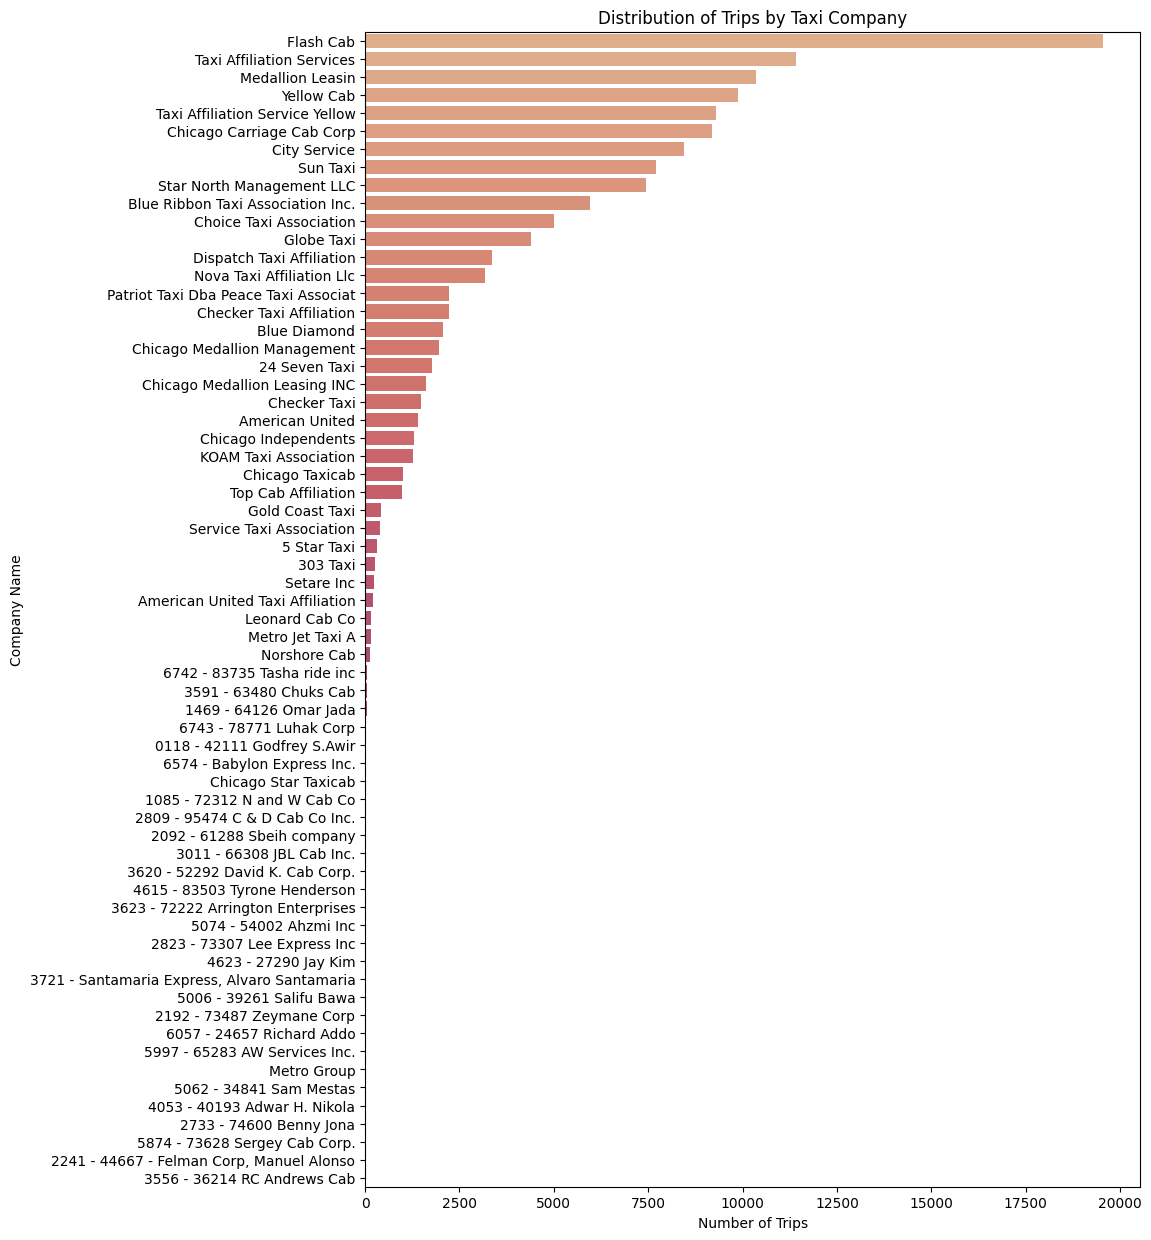

In [8]:
fig = sns.barplot(data=df_taxis, y='company_name', x='trips_amount', palette='flare')
fig.set_ylabel('Company Name')
fig.set_xlabel('Number of Trips')
fig.set_title('Distribution of Trips by Taxi Company')
fig.figure.set_size_inches(10, 15)

Roughly half of the taxi companies contained in the dataset had no trips recorded on November 15-16, 2017. Flash Cab is the most used taxi service by a significant margin with about 20,000 trips recorded in the two day span. The second most used service is Taxi Affiliation Services at just under 12,000 trips, then the number of trips for the remaining companies appear to decrease logrithmically. There could be a number of factors that contribute to this result, such as company fleet size, service location, and customer preference.

Text(0.5, 1.0, 'Average Number of Trips for Top 10 Dropoff Locations')

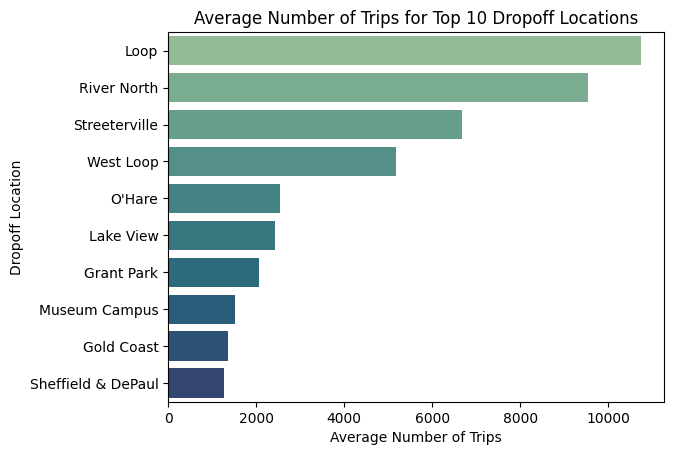

In [9]:
fig = sns.barplot(data=df_top10_dropoffs, y='dropoff_location_name', x='average_trips', palette='crest')
fig.set_ylabel('Dropoff Location')
fig.set_xlabel('Average Number of Trips')
fig.set_title('Average Number of Trips for Top 10 Dropoff Locations')

Based on the graph above, Loop and River North are the most frequent dropoff locations in Novemeber 2017 with approximately 10,000 trips. Streeterville and West Loop also have a decent number of trips, but the remaining locations don't appear to be frequently selected as the destination for the listed taxi services. Again, there could be a number of factors impacting these numbers such as population size for each neighborhood and taxi service availability.

## Hypothesis Testing ##

As previously stated, we've analyze the provided data to determine if external factors impact ride frequency and customer preference. Based on the weather and ride frequency data, we want to test the following hypothesis:

- $H_0$: The average duration of rides from the Loop to O'Hare International Airport on poor-weather Saturdays is the same as fair-weather Saturdays.  
- $H_A$: The average duration of rides from the Loop to O'Hare International Airport on poor-weather Saturdays is different as fair-weather Saturdays.

With a relatively small dataset and no need for a restrictive statistical significance, we'll set our alpha to 5%. For our t-test, we're comparing the equality of the means of two populations, thus we'll incorporate the <code>ttest_ind()</code> method, and the Levene test to examine their variance equality. Sample_1 will contain the average durations for bad-weather Saturday trips and Sample_2 will contain the average durations for good-weather Saturdays trips.

In [10]:
sample_1 = df_loop_ohare_trips[df_loop_ohare_trips['weather_conditions'] == 'Bad']['duration_seconds']
sample_2 = df_loop_ohare_trips[df_loop_ohare_trips['weather_conditions'] == 'Good']['duration_seconds']

print('Levene p-value: ', st.levene(sample_1, sample_2, center='median').pvalue)

Levene p-value:  0.5332038671974493


The Levene test p-value is significantly higher than 1%, indicating we have met the assumption for homogeneity in variance. As such, the equal_var( ) parameter will be set to True.

In [11]:
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, equal_var = True)
                             
print('T-test p-value: ', results.pvalue)

# if the p-value is less than alpha, we reject the hypothesis
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

T-test p-value:  6.517970327099473e-12
We reject the null hypothesis


The result of the hypothesis tests indicates there is not enough statistical significance to suggest that the two sample means are the same. It appears weather may have an impact to ride frequency.

## Conclusion

Based on the data analysis, the ride share company may be able to optimize their business strategy knowing a few key takeaways. Fleet availability and service routes should be prioritzed for the Loop and River North areas as these locations were the most frequent dropoff locations in November. From our hypothesis test, we learned poor weather will likely impact customer ride frqeuency. Lastly, more information can be gleaned by looking at the most popular taxi competitor, Flash Cab, as they had the highest number of trips than other taxi companies by a significant margin.